In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 749ms/step - loss: 1.6082e-05
Average validation loss: 0.6720807552337646
4/4 [==============================] - 7s 765ms/step - loss: 1.6082e-05 - val_loss: 0.6721
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 739ms/step - loss: 1.3654e-05 - val_loss: 0.6721
Average validation loss: 0.640710711479187
4/4 [==============================] - 10s 756ms/step - loss: 1.3654e-05 - val_loss: 0.6564
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 739ms/step - loss: 1.1409e-05 - val_loss: 0.6564
Average validation loss: 0.5810240507125854
4/4 [==============================] - 13s 751ms/step - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 698ms/step - loss: 6.8222e-07
Average validation loss: 0.0009662318334449083
8/8 [==============================] - 6s 707ms/step - loss: 6.8222e-07 - val_loss: 9.6623e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 678ms/step - loss: 6.4934e-07 - val_loss: 9.6623e-04
Average validation loss: 0.0010846829391084611
8/8 [==============================] - 11s 688ms/step - loss: 6.4934e-07 - val_loss: 0.0010    
Epoch 3/10
8/8 [==============================] - 17s 679ms/step - loss: 6.4036e-07 - val_loss: 0.0010
Average validation loss: 0.0027047012699767947
8/8 [==============================] - 17s 688ms/step - loss: 6.4036e-07 - val_loss: 0.0016
Epoch 4/10
8/8 [==============================] - 22s 681ms/step - loss: 6.2314e-07 - val_loss: 0.0016
Average valida

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 679ms/step - loss: 8.9144e-07
Average validation loss: 0.0769203130985261
12/12 [==============================] - 8s 690ms/step - loss: 8.9144e-07 - val_loss: 0.0769
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 16s 678ms/step - loss: 9.1197e-07 - val_loss: 0.0769
Average validation loss: 0.04983133380301297
12/12 [==============================] - 17s 689ms/step - loss: 9.1197e-07 - val_loss: 0.0634
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 683ms/step - loss: 8.6286e-07 - val_loss: 0.0634
Average validation loss: 0.058554922114126384
12/12 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 726ms/step - loss: 5.4631e-07
Average validation loss: 0.05115095939254388
16/16 [==============================] - 12s 736ms/step - loss: 5.4631e-07 - val_loss: 0.0512
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 694ms/step - loss: 5.2063e-07 - val_loss: 0.0512
Average validation loss: 0.057216065702959895
16/16 [==============================] - 23s 706ms/step - loss: 5.2063e-07 - val_loss: 0.0542
Epoch 3/10
16/16 [==============================] - 34s 692ms/step - loss: 4.8899e-07 - val_loss: 0.0542
Average validation loss: 0.05010703147854656
16/16 [==============================] - 34s 702ms/step - loss: 4.8899e-07 - val_loss: 0.0528
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 695ms/step - loss: 3.6989e-07
Average validation loss: 0.07194785894826054
20/20 [==============================] - 14s 705ms/step - loss: 3.6989e-07 - val_loss: 0.0719
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 683ms/step - loss: 3.7460e-07 - val_loss: 0.0719
Average validation loss: 0.10624677585437894
20/20 [==============================] - 28s 693ms/step - loss: 3.7460e-07 - val_loss: 0.0891
Epoch 3/10
20/20 [==============================] - 42s 685ms/step - loss: 3.6073e-07 - val_loss: 0.0891
Average validation loss: 0.10272137271240353
20/20 [==============================] - 42s 696ms/step - loss: 3.6073e-07 - val_loss: 0.0936
Epoch 4/10
20/20 [==============================] - 56s 683ms/step - loss: 3.3259e-07 - val_loss: 0.0936
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 693ms/step - loss: 6.4028e-07
Average validation loss: 0.08244941135247548
24/24 [==============================] - 17s 702ms/step - loss: 6.4028e-07 - val_loss: 0.0824
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 33s 684ms/step - loss: 4.9858e-07 - val_loss: 0.0824
Average validation loss: 0.10360012700160344
24/24 [==============================] - 34s 693ms/step - loss: 4.9858e-07 - val_loss: 0.0930
Epoch 3/10
24/24 [==============================] - 50s 684ms/step - loss: 4.1781e-07 - val_loss: 0.0930
Average validation loss: 0.07644309538106124
24/24 [==============================] - 50s 693ms/step - loss: 4.1781e-07 - val_loss: 0.0875
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 681ms/step - loss: 6.3258e-07
Average validation loss: 0.0834129337221384
40/40 [==============================] - 28s 691ms/step - loss: 6.3258e-07 - val_loss: 0.0834
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 688ms/step - loss: 5.1639e-07 - val_loss: 0.0834
Average validation loss: 0.16686818413436413
40/40 [==============================] - 56s 697ms/step - loss: 5.1639e-07 - val_loss: 0.1251
Epoch 3/10
40/40 [==============================] - 83s 691ms/step - loss: 4.2937e-07 - val_loss: 0.1251
Average validation loss: 0.12370633855462074
40/40 [==============================] - 84s 700ms/step - loss: 4.2937e-07 - val_loss: 0.1247
Epoch 4/10
40/40 [==============================] - 111s 690ms/step - loss: 3.7741e-07 - val_loss: 0.1247
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 696ms/step - loss: 2.8758e-07
Average validation loss: 0.09178481639052431
48/48 [==============================] - 34s 707ms/step - loss: 2.8758e-07 - val_loss: 0.0918
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 703ms/step - loss: 2.2764e-07 - val_loss: 0.0918
Average validation loss: 0.07991028235604365
48/48 [==============================] - 68s 713ms/step - loss: 2.2764e-07 - val_loss: 0.0858
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 102s 695ms/step - loss: 1.9022e-07 - val_loss: 0.0858
Average validation loss: 0.08060039253905416
48/48 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 672ms/step - loss: 2.1344e-07
Average validation loss: 0.10432450134041053
56/56 [==============================] - 38s 681ms/step - loss: 2.1344e-07 - val_loss: 0.1043
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 77s 685ms/step - loss: 1.7457e-07 - val_loss: 0.1043
Average validation loss: 0.10160871176049113
56/56 [==============================] - 77s 694ms/step - loss: 1.7457e-07 - val_loss: 0.1030
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 116s 702ms/step - loss: 1.4261e-07 - val_loss: 0.1030
Average validation loss: 0.09819021947415811
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 693ms/step - loss: 2.7742e-07
Average validation loss: 0.09700502315536141
64/64 [==============================] - 45s 702ms/step - loss: 2.7742e-07 - val_loss: 0.0970
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 698ms/step - loss: 2.0491e-07 - val_loss: 0.0970
Average validation loss: 0.09707527351565659
64/64 [==============================] - 90s 708ms/step - loss: 2.0491e-07 - val_loss: 0.0970
Epoch 3/10
64/64 [==============================] - 135s 692ms/step - loss: 1.6259e-07 - val_loss: 0.0970
Average validation loss: 0.08530431624967605
64/64 [==============================] - 135s 702ms/step - loss: 1.6259e-07 - val_loss: 0.0931
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/w

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 701ms/step - loss: 1.6890e-07
Average validation loss: 0.09965397189888689
72/72 [==============================] - 51s 711ms/step - loss: 1.6890e-07 - val_loss: 0.0997
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 690ms/step - loss: 1.2744e-07 - val_loss: 0.0997
Average validation loss: 0.06793791262639894
72/72 [==============================] - 102s 700ms/step - loss: 1.2744e-07 - val_loss: 0.0838
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 152s 694ms/step - loss: 1.0255e-07 - val_loss: 0.0838
Average validation loss: 0.09698071185913351
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 61s 760ms/step - loss: 2.3336e-07
Average validation loss: 0.11562216710299253
80/80 [==============================] - 62s 771ms/step - loss: 2.3336e-07 - val_loss: 0.1156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 120s 723ms/step - loss: 1.6131e-07 - val_loss: 0.1156
Average validation loss: 0.08495611771941185
80/80 [==============================] - 120s 733ms/step - loss: 1.6131e-07 - val_loss: 0.1003
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 176s 697ms/step - loss: 1.3612e-07 - val_loss: 0.1003
Average validation loss: 0.07627785783261061
80/80 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 700ms/step - loss: 3.5247e-07
Average validation loss: 0.16969029617030174
96/96 [==============================] - 68s 710ms/step - loss: 3.5247e-07 - val_loss: 0.1697
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 701ms/step - loss: 2.4627e-07 - val_loss: 0.1697
Average validation loss: 0.12217434806128342
96/96 [==============================] - 137s 711ms/step - loss: 2.4627e-07 - val_loss: 0.1459
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 712ms/step - loss: 1.9574e-07 - val_loss: 0.1459
Average validation loss: 0.1259336331859231
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 697ms/step - loss: 3.2393e-07
Average validation loss: 0.12291531520119557
120/120 [==============================] - 85s 707ms/step - loss: 3.2393e-07 - val_loss: 0.1229
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 712ms/step - loss: 2.4498e-07 - val_loss: 0.1229
Average validation loss: 0.08729694650198022
120/120 [==============================] - 172s 722ms/step - loss: 2.4498e-07 - val_loss: 0.1051
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 256s 702ms/step - loss: 2.0047e-07 - val_loss: 0.1051
Average validation loss: 0.1053595611670365
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 698ms/step - loss: 2.3384e-07
Average validation loss: 0.08542998247624685
144/144 [==============================] - 102s 708ms/step - loss: 2.3384e-07 - val_loss: 0.0854
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 706ms/step - loss: 1.8099e-07 - val_loss: 0.0854
Average validation loss: 0.0866181335101525
144/144 [==============================] - 205s 716ms/step - loss: 1.8099e-07 - val_loss: 0.0860
Epoch 3/10
144/144 [==============================] - 306s 698ms/step - loss: 1.5207e-07 - val_loss: 0.0860
Average validation loss: 0.08584621434824334
144/144 [==============================] - 307s 708ms/step - loss: 1.5207e-07 - val_loss: 0.0860
Epoch 4/10
144/144 [==============================] - 408s 699ms/step - loss: 1.3166e-07 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 701ms/step - loss: 1.8198e-07
Average validation loss: 0.10662810730864294
160/160 [==============================] - 114s 711ms/step - loss: 1.8198e-07 - val_loss: 0.1066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 226s 702ms/step - loss: 1.3992e-07 - val_loss: 0.1066
Average validation loss: 0.11261031540925615
160/160 [==============================] - 228s 712ms/step - loss: 1.3992e-07 - val_loss: 0.1096
Epoch 3/10
160/160 [==============================] - 339s 697ms/step - loss: 1.2650e-07 - val_loss: 0.1096
Average validation loss: 0.07711328442965168
160/160 [==============================] - 341s 707ms/step - loss: 1.2650e-07 - val_loss: 0.0988
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 718ms/step - loss: 3.4240e-07
Average validation loss: 0.08770622030831873
200/200 [==============================] - 146s 729ms/step - loss: 3.4240e-07 - val_loss: 0.0877
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 714ms/step - loss: 2.9232e-07 - val_loss: 0.0877
Average validation loss: 0.058461769805289804
200/200 [==============================] - 291s 724ms/step - loss: 2.9232e-07 - val_loss: 0.0731
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 435s 721ms/step - loss: 2.5063e-07 - val_loss: 0.0731
Average validation loss: 0.09687206200323999
200/200 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:49 - loss: 2.2545e-08

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 703ms/step - loss: 1.9040e-07
Average validation loss: 0.09580561075514803
240/240 [==============================] - 171s 713ms/step - loss: 1.9040e-07 - val_loss: 0.0958
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 703ms/step - loss: 1.4331e-07 - val_loss: 0.0958
Average validation loss: 0.08042957553795228
240/240 [==============================] - 342s 713ms/step - loss: 1.4331e-07 - val_loss: 0.0881
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 511s 703ms/step - loss: 1.1555e-07 - val_loss: 0.0881
Average validation loss: 0.0982274635345675
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10625322641135426, 0.0498852001947489, 0.07249373426035163, 0.08663404649472796, 0.07756986574549227, 0.07479769700206818, 0.103517724535428, 0.08879359518488249, 0.09800089308326798, 0.09635285878437572, 0.08088305867121864, 0.07896670298930257, 0.0965075414387199, 0.09349878043650339, 0.07769772365352967, 0.07890514236624585, 0.07830409443723038, 0.0716505495099506]
std_val_losses =  [0.18435321610025476, 0.04020114820843405, 0.031206003028316418, 0.03132159442196993, 0.013133821956970106, 0.027357225421136278, 0.024548727860843646, 0.014083009156946085, 0.027276737005670956, 0.01779290872508358, 0.01263536912501655, 0.012117248343210289, 0.030332720702502675, 0.020338061010733183, 0.012918746222610864, 0.0179777286236367, 0.011975203788949717, 0.01622030473196222]


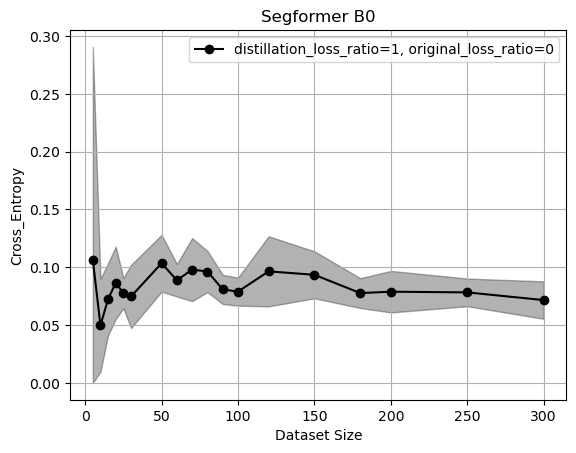

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()